<a href="https://colab.research.google.com/github/Flo909/GraspandLiftDetection/blob/main/Copy_of_Assignment_3_Ben.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Test Xanthe
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

import tensorflow

from matplotlib import pyplot as plt

run_on_colab = True

# Training will be significantly faster if GPU is available. In Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")
# set the device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


GPU is available


Import data:
Download the train.zip file from https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data and
explore the dataset. This file contains the first 8 series for each subject. (We will be only using
train.zip for the project.)
There are two files for each subject + series combination:
● the *_data.csv files contain the raw 32 channels EEG data (sampling rate 500Hz)
● the *_events.csv files contains the ground truth frame-wise labels for all events

NOTE: to import the data you have to log into kaggle and create an API token. From there you upload the kaggle.json file that will be downloaded when creating the API token and upload it into the connected google drive account for colab. Then give colab permission to access the files when running the below lines.

In [8]:
if (run_on_colab):
  ! pip install kaggle

In [11]:
if (run_on_colab):
  from google.colab import drive
  drive.mount('/content/drive')
  ! mkdir ~/.kaggle
  ! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [12]:
! kaggle competitions download grasp-and-lift-eeg-detection --force

 98% 1.00G/1.02G [00:14<00:00, 115MB/s]
100% 1.02G/1.02G [00:14<00:00, 73.2MB/s]


In [13]:
import zipfile
import pandas as pd
import os

# Open the zip file
with zipfile.ZipFile('grasp-and-lift-eeg-detection.zip', 'r') as zip_ref:
    # Extract all files
    zip_ref.extractall('grasp-and-lift-eeg-detection')

# List the extracted files
extracted_files = zip_ref.namelist()

display(extracted_files)

['sample_submission.csv.zip', 'test.zip', 'train.zip']

In [14]:
# Extracted folder name will be the same as the zip file name without the extension
extracted_folder = os.path.splitext('grasp-and-lift-eeg-detection/train.zip')[0]

with zipfile.ZipFile('grasp-and-lift-eeg-detection/train.zip', 'r') as zip_ref:
    # Extract all files
    zip_ref.extractall(extracted_folder)

extracted_files = zip_ref.namelist()

# Visualise the data


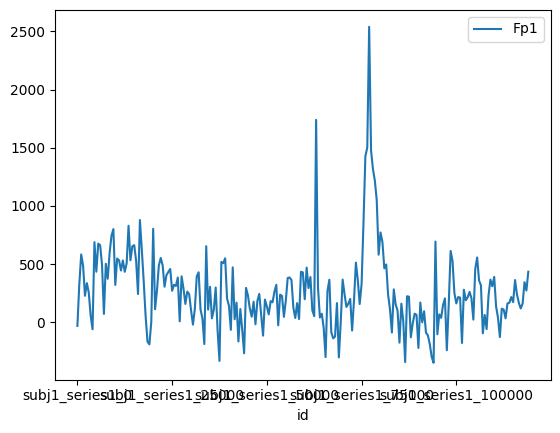

In [15]:
import matplotlib.pyplot as plt

train_set_signals = pd.read_csv("grasp-and-lift-eeg-detection/train/train/subj1_series1_data.csv")
train_set_signals.head()
axis = plt.gca()
downSampleToShow = 500
train_set_signals[::downSampleToShow].plot(x="id", y="Fp1", ax=axis)

plt.show()
train_set_signals[::downSampleToShow].plot(x="id", y="PO10", ax=axis, figsize=(15,5))
plt.show()

In [16]:
# Function to read data and labels
def read_data_and_labels(extracted_files, extracted_folder):
    train_data = []
    val_data = []
    test_labels = []
    train_labels = []

    for file_name in extracted_files:
        if file_name.endswith('_data.csv'):
            subject_id, series = file_name.split('_')[:2]
            df = pd.read_csv(os.path.join(extracted_folder, file_name))
            df.drop(columns = ['id'], inplace=True)
            if series == 'series7' or series == 'series8':
                val_data.append(df.T.astype(np.float32))
            else:
                train_data.append(df.T.astype(np.float32))

        elif file_name.endswith('_events.csv'):
            subject_id, series = file_name.split('_')[:2]
            labels_df = pd.read_csv(os.path.join(extracted_folder, file_name))
            labels_df.drop(columns =['id'], inplace=True)
            if series == 'series7' or series == 'series8':
              test_labels.append(labels_df.T.astype(np.float32))
            else:
              train_labels.append(labels_df.T.astype(np.float32))


    return train_data, val_data, test_labels, train_labels

# Read data and labels
train_data, val_data, test_labels, train_labels = read_data_and_labels(extracted_files, extracted_folder)



# Create dataset class
Note: example gets rid of long chunks of data with no events-> could be something to look into

In [41]:
import torch
from torch.utils.data import Dataset, DataLoader

# Custom Dataset Class
class EEGDataset(Dataset):
    def __init__(self, data, labels, in_len, normalise, test, train_mean = 0, train_std = 1):
        index = ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'Cz', 'C4', 'T8', 'TP9', 'CP5', 'CP1', 'CP2', 'CP6', 'TP10', 'P7', 'P3', 'Pz', 'P4', 'P8', 'PO9', 'O1', 'Oz', 'O2', 'PO10']
        self.data = data
        self.labels = labels
        self.in_len = in_len
        if not test:
          self.mean = pd.series(np.concatenate(self.data,axis=1).mean(axis=0),index=index)
          self.std = pd.series(np.concatenate(self.data,axis=1).std(axis=0),index=index)
        else:
          self.mean = train_mean
          self.std = train_std
        self.normalised = normalise

        if self.normalised:
          self.normalise()

        self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]



    def __len__(self):
        return len(self.index)
        #return len(self.data)

    def getmean(self):
      return self.mean

    def getstd(self):
      return self.std

    def normalise(self):
        # for each column of the data, subtract mean
        for i in range(len(self.data)):
          self.data[i] = self.data[i].sub(self.mean,axis=0)
          self.data[i] = self.data[i].sub(self.std,axis=0)

    def __getitem__(self, idx):

        i, j = self.index[idx]

        data, labels = self.data[i].iloc[:,max(0, j - self.in_len + 1):j + 1], self.labels[i].iloc[:,j]
        #print('checkpoint')
        data_array = np.array(data, dtype=np.float32)
        labels_array = np.array(labels, dtype=np.float32)

        if (data_array.shape[1] < self.in_len):
          data_array = np.pad(data_array, ((0,0),(self.in_len-data.shape[1],0)),mode='edge')#, constant_values=np.float32(0.0))

        data, label = torch.from_numpy(data_array.astype(np.float32)), torch.from_numpy(labels_array.astype(np.float32))
        #data, label = torch.from_numpy(np.array(data, dtype=np.float32)), torch.from_numpy(np.array(labels, dtype=np.float32))
        return data, label


# Create Dataset instances
# final argument must be an ingeger between 1 and 33 -> the larger the number the more computationally complex
print(np.concatenate(train_data,axis=1).mean(axis=1))
print(train_data[0])
in_len = 128
normalise = True
test = False
train_dataset = EEGDataset(train_data, train_labels, in_len, normalise, test)
train_mean = train_dataset.getmean()
train_std = train_dataset.getstd()

# The validation and test sets use the mean and standard deviation from train
# As this is all that's available to the model. When test is set to true,
# pass in the train mean and std
normalise = True
test = True
val_dataset = EEGDataset(val_data, test_labels, in_len, normalise, test, train_mean, train_std)

data_loader = DataLoader(train_dataset, batch_size=1024)
val_loader = DataLoader(val_dataset, batch_size=1024)


[ 1.6521321e+02  1.9680322e+02  3.4010010e+02  1.3676856e+01
 -9.4881785e-01  2.9744266e+02  1.2525447e+01  2.9855212e+02
  6.8403191e+01 -1.6403246e+00  1.3097963e+02  6.5670807e+01
  3.0193024e+02 -3.1330526e+00  1.0008968e+02  6.8126343e+01
  6.1008999e+01  1.8025743e+01  3.7268856e+01  5.1823277e+01
 -5.6799397e+01  1.6299698e+02  2.1790497e+02  9.6748260e+01
  1.3691936e+02  1.5809033e+02  2.3933929e+02 -2.8873249e+01
  1.6178569e+02 -3.4979079e+00 -4.7365791e+01 -3.3007589e-01]
      0       1       2       3       4       5       6       7       8       \
Fp1   -304.0  -300.0  -286.0  -281.0  -294.0  -297.0  -286.0  -249.0  -295.0   
Fp2   -156.0  -151.0  -227.0  -272.0  -194.0  -132.0  -124.0  -131.0  -171.0   
F7    -411.0  -376.0  -400.0  -447.0  -432.0  -406.0  -372.0  -307.0  -286.0   
F3    -640.0  -670.0  -724.0  -702.0  -693.0  -685.0  -677.0  -630.0  -667.0   
Fz    -505.0  -509.0  -525.0  -540.0  -503.0  -526.0  -531.0  -506.0  -505.0   
F4    -603.0  -622.0  -631.0  -

ValueError: Unable to coerce to Series, length must be 262387: given 14819347

In [ ]:
#print(train_dataset.shape)
"""
for i in range(len(train_data)):
  #print (train_data[i].shape[1])
  if (train_data[i].shape[1] != train_labels[i].shape[1]):
    print("error match")
  if (train_data[i].shape[0] != 32):
    print("error dim")

for i in range(len(train_labels)):
  print (train_labels[i].shape[1])
  if (train_labels[i].shape[0] != 6):
    print("error dim")
"""
"""
nested_list = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]
nested_array = np.array(nested_list)
print(nested_array)


#print(type(train_data[0]))
#print(train_data[0].iloc[:,0:2])

print(train_dataset[100][0].shape)
print(len(train_dataset))
for inputs, labels in dataLoader:
    print("Input shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break
#print(train_dataset[]
#print([(i, j) for i in range(len(train_data)) for j in range(train_data[i].shape[1])])
#print(train_data[0][1][0])
#print([len(train_data[0][i]) for i in range(len(train_data[0]))])

ARchitectures to look at
1)Inception
2)Densenets
3)Resnets
"""
#print(train_dataset[500][0].shape)
max_pool1 = nn.MaxPool1d(16,16)
print(max_pool1(torch.from_numpy(np.random(16,1))))

# Create a Neural Network


In [ ]:
# Define the CNN architecture
class EEGCNN(nn.Module):
    def __init__(self):
        self.channels = 32
        self.outchannels = 32
        super(EEGCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels= self.channels, out_channels= self.channels, kernel_size=3, stride=1, padding=1, groups=self.channels)
        self.conv2 = nn.Conv1d(in_channels= self.channels, out_channels= self.channels, kernel_size=3, stride=1, padding=1, groups=self.channels)
        self.conv3 = nn.Conv1d(in_channels= self.channels, out_channels= self.channels, kernel_size=3, stride=1, padding=1, groups=self.channels)
        #self.conv2 = nn.Conv1d(in_channels= self.inchannels, out_channels= self.outchannels, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool_large = nn.MaxPool1d(kernel_size=8, stride=8)
        self.fc1 = nn.Linear(self.channels*2, 6)
        #self.fc1 = nn.Linear(32 * 125, 128)
        self.fc2 = nn.Linear(128, 6)

    def forward(self, x):
        #64 -> 32
        x = self.pool(torch.relu(self.conv1(x)))
        #32 -> 16
        x = self.pool(torch.relu(self.conv2(x)))
        #16 -> 2
        #print('check1')
        x = self.pool_large(torch.relu(self.conv3(x)))
        #x = self.pool(torch.relu(self.conv1(x)))
        #print(x.shape)
        #x = self.pool(x)
        x = x.view(-1, self.channels * 2)  # Flattening
        x = torch.relu(self.fc1(x))
        #x = self.fc2(x)
        return x



In [ ]:
def dataloader_validation(loader):
  input, label = loader.dataset[0]
  print(label)
  print(input)
  return

#dataloader_validation(dataLoader)

In [ ]:
from tqdm import tqdm

# Define model
model = EEGCNN().to(device)

# Define your loss function
criterion = nn.CrossEntropyLoss()

# Define your optimizer
optimizer = optim.Adam(model.parameters(), lr=0.002)

# Set the number of epochs
num_epochs = 4

# Lists to store the training and validation losses and accuracies
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set the model to training mode
    model.train()

    # Initialize the training loss and accuracy for this epoch
    train_loss = 0
    train_correct = 0
    train_total = 0

    # Iterate over the training data
    for inputs, labels in tqdm(data_loader):

        # Move the inputs and labels to the GPU if available
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the gradients
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(inputs.shape)
        #print(outputs.shape)
        #print(labels.shape)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()
        # Update the training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, labels_reshape = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels_reshape.size(0)
        train_correct += (predicted == labels_reshape).sum().item()


    # Compute the average training loss and accuracy for this epoch
    train_loss /= len(data_loader.dataset)
    train_accuracy = 100 * train_correct / train_total

    # Append the training loss and accuracy to the lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Set the model to evaluation mode
    model.eval()

    # Initialize the validation loss and accuracy for this epoch
    val_loss = 0
    val_correct = 0
    val_total = 0

    # Calculate the validation loss and accuracy and append to the lists
    with torch.no_grad():
      for inputs, labels in tqdm(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)

        loss = criterion(outputs, labels)

        val_loss += loss.item() * inputs.size(0)
        _, labels_reshape = torch.max(labels, 1)
        _, predicted = torch.max(outputs.data, 1)
        val_total += labels_reshape.size(0)
        val_correct += (predicted == labels_reshape).sum().item()

    # Compute the average validation loss and accuracy for this epoch
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * val_correct / val_total

    # Append the validation loss and accuracy to the listsy
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print the training and validation metrics for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")
    print()

#Filtering
Filtering the Data
(maybe do this after we actually have a nn)


In [ ]:
import matplotlib.pyplot as plt
from scipy import signal

# Making a copy of the dataset so as the maintain the original
filtered_train = train_dataset
filtered_test = val_dataset

def filter_eeg_dataset(EEGDataset, f_low, f_high, order, type, fs):
  b, a = signal.butter(order, [f_low, f_high], btype=type, fs=fs)

  subject_names = EEGDataset.subject_names

  # For each Subject in EEG Dataset
  for subject in subject_names:
    # For each Series in Subject
    for series in range(6):
      try:
        data_trial = EEGDataset.subjects[subject][series]
        # For each Column in series and subject
        # Not the first non-numerical columns
        for col_name in data_trial.columns:

          if col_name != "id":
            filtered_data = signal.filtfilt(b, a, data_trial[col_name])

            # Replace data
            EEGDataset.subjects[subject][series][col_name] = filtered_data


      # Breaking when we run out of series
      except IndexError as e:
        print(str(subject) + " caps at "+ str(series))
        break




# System Params
order = 4
sampling_frequency = 500

# High and Low Pass Filter
f_low = 1
f_high = 100
f_type = 'bandpass'

filter_eeg_dataset(filtered_train, f_low, f_high, order, f_type, sampling_frequency)
filter_eeg_dataset(filtered_test, f_low, f_high, order, f_type, sampling_frequency)

# Bandreject
f_low = 49
f_high = 51
f_type = 'bandstop'

filter_eeg_dataset(filtered_train, f_low, f_high, order, f_type, sampling_frequency)
filter_eeg_dataset(filtered_test, f_low, f_high, order, f_type, sampling_frequency)

Feature Extraction
